In [488]:
%reset -f
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import familiarization as fam

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import KBinsDiscretizer

# data_9 = fam.load_data("data/capture20110817.binetflow.txt")
data = fam.load_data("data/capture20110818.binetflow.txt")
# data_11 = fam.load_data("data/capture20110818-2.binetflow.txt")
# data_12 = fam.load_data("data/capture20110819.binetflow.txt")

In [491]:
pdata = fam.pre_process(data)
pdata.head()

,StartTime,Duration,Protocol,SourceAddress,SourcePort,Direction,DestinationAddress,DestinationPort,TotalPackets,TotalBytes,SourceBytes,Label,Infected
407,2011/08/18 10:19:15.693956,3587.569824,TCP,147.32.84.164,54784,<?>,74.125.232.215,443,3049,978731,245317,flow=From-Normal-V51-Grill,0
697,2011/08/18 10:19:18.143576,198.072739,TCP,147.32.84.164,56165,<?>,74.125.232.197,80,14,924,462,flow=From-Normal-V51-Grill,0
717,2011/08/18 10:19:18.303590,197.928329,TCP,147.32.84.164,57965,<?>,209.85.149.138,80,14,924,462,flow=From-Normal-V51-Grill,0
896,2011/08/18 10:19:19.838272,0.000399,UDP,147.32.84.170,45807,<->,147.32.80.9,53,2,400,74,flow=From-Normal-V51-Stribrek,0
897,2011/08/18 10:19:19.839123,0.000400,UDP,147.32.84.170,35380,<->,147.32.80.9,53,2,400,74,flow=From-Normal-V51-Stribrek,0


In [492]:
infected_hosts = pdata.loc[pdata["Infected"] == 1]
non_infected_hosts = pdata.loc[pdata["Infected"] == 0]
print(len(pdata),len(infected_hosts), len(non_infected_hosts))
infected_hosts.head()

122199 106352 15847


,StartTime,Duration,Protocol,SourceAddress,SourcePort,Direction,DestinationAddress,DestinationPort,TotalPackets,TotalBytes,SourceBytes,Label,Infected
90529,2011/08/18 10:37:58.448307,0.000342,UDP,147.32.84.165,1025,<->,147.32.80.9,53,2,203,64,flow=From-Botnet-V51-1-UDP-DNS,1
90715,2011/08/18 10:38:00.695278,0.010278,UDP,147.32.84.165,1025,<->,147.32.80.9,53,2,590,87,flow=From-Botnet-V51-1-UDP-DNS,1
90716,2011/08/18 10:38:00.706560,0.043726,TCP,147.32.84.165,1027,->,74.125.232.206,80,7,882,629,flow=From-Botnet-V51-1-TCP-HTTP-Google-Net-Est...,1
90872,2011/08/18 10:38:03.255934,0.010256,UDP,147.32.84.165,1025,<->,147.32.80.9,53,2,479,76,flow=From-Botnet-V51-1-UDP-DNS,1
90875,2011/08/18 10:38:03.267222,581.516663,UDP,147.32.84.165,123,->,65.55.56.40,123,4,360,360,flow=From-Botnet-V51-1-UDP-Attempt,1


In [4]:
infected_hosts.describe()

,Duration,TotalPackets,TotalBytes,SourceBytes,Infected
count,106352.000000,106352.000000,1.063520e+05,1.063520e+05,106352.0
mean,90.825592,30.315330,2.712966e+04,2.712120e+04,1.0
std,292.015024,1741.181013,1.388200e+06,1.388200e+06,0.0
min,0.000000,1.000000,6.000000e+01,6.000000e+01,1.0
25%,0.000000,1.000000,1.066000e+03,1.066000e+03,1.0
50%,0.000000,1.000000,1.066000e+03,1.066000e+03,1.0
75%,0.000000,1.000000,1.066000e+03,1.066000e+03,1.0
max,3594.721436,176254.000000,1.387386e+08,1.387386e+08,1.0


In [5]:
non_infected_hosts.describe()

,Duration,TotalPackets,TotalBytes,SourceBytes,Infected
count,15847.000000,15847.000000,1.584700e+04,1.584700e+04,15847.0
mean,46.585670,35.749164,2.719936e+04,1.660341e+03,0.0
std,301.233657,506.146679,4.707149e+05,1.838861e+04,0.0
min,0.000000,1.000000,6.600000e+01,0.000000e+00,0.0
25%,0.000318,2.000000,2.440000e+02,7.400000e+01,0.0
50%,0.000480,2.000000,4.000000e+02,8.100000e+01,0.0
75%,0.112268,6.000000,4.780000e+02,2.720000e+02,0.0
max,3599.957031,32630.000000,3.048162e+07,1.136051e+06,0.0


In [6]:
# Compare statistics for infected and non-infected hosts
## Average Duration
duration_infected = np.mean(infected_hosts["Duration"])
duration_non_infected = np.mean(non_infected_hosts["Duration"])

## Protocol
protocols_infected = infected_hosts.Protocol.value_counts(normalize=True)
protocols_non_infected = non_infected_hosts.Protocol.value_counts(normalize=True)

## Average TotalPackets
packets_infected = np.mean(infected_hosts.TotalPackets)
packets_non_infected = np.mean(non_infected_hosts.TotalPackets)

## Average TotalBytes
bytes_infected = np.mean(infected_hosts.TotalBytes)
bytes_non_infected = np.mean(non_infected_hosts.TotalBytes)

## Average SourceBytes
source_bytes_infected = np.mean(infected_hosts.SourceBytes)
source_bytes_non_infected = np.mean(non_infected_hosts.SourceBytes)

print("Infected hosts")
print(" Duration:", duration_infected)
print(" Protocols: \n",protocols_infected)
print(" Average Packets",packets_infected)
print(" Average Bytes",bytes_infected)
print(" Source Bytes",source_bytes_infected)

print("\n")
print("Non-Infected hosts")
print(" Duration:", duration_non_infected)
print(" Protocols: \n",protocols_non_infected)
print(" Average Packets",packets_non_infected)
print(" Average Bytes",bytes_non_infected)
print(" Source Bytes",source_bytes_non_infected)

Infected hosts
 Duration: 90.82559153096324
 Protocols: 
 ICMP    0.996474
UDP     0.002755
TCP     0.000771
Name: Protocol, dtype: float64
 Average Packets 30.315330224161276
 Average Bytes 27129.65718557244
 Source Bytes 27121.20417105461


Non-Infected hosts
 Duration: 46.58566988862245
 Protocols: 
 UDP     0.617152
TCP     0.337162
ICMP    0.044993
ARP     0.000694
Name: Protocol, dtype: float64
 Average Packets 35.74916387959866
 Average Bytes 27199.363854357292
 Source Bytes 1660.3409478134663


The statistics are clear in the differences between the infected and non-infected hosts:
- The duration for flows from infected hosts is about twice the time as for non-infected hosts
- Almost all flow from the infected hosts use the ICMP protocol, while UDP and TCP are most popular for non-infected hosts
- The total number of packets and bytes do not differ much between both hosts
- The bytes sent by infected hosts are a lot higher for infected hosts

The two features that stand out most are the ICMP protocol and Duration/SourceBytes

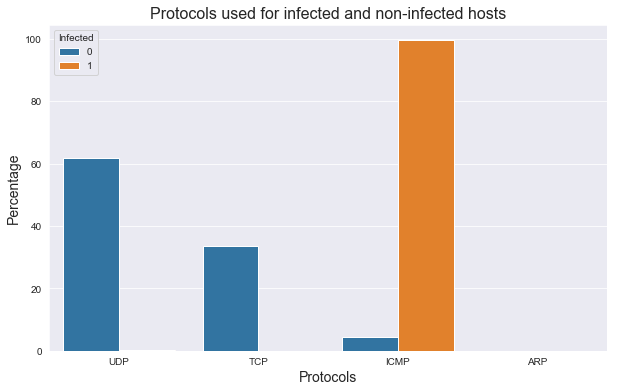

In [29]:
# Visualize protocols used
protocol_grouped = pdata.groupby('Infected')['Protocol'].value_counts(normalize=True)
protocol_grouped = protocol_grouped.mul(100)
protocol_grouped = protocol_grouped.rename('percent').reset_index()

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x='Protocol',y='percent',hue='Infected',data=protocol_grouped)
ax.set_title("Protocols used for infected and non-infected hosts",size=16)
ax.set_ylabel("Percentage",size=14)
ax.set_xlabel("Protocols",size=14)
plt.show()

In [371]:
pdata.Direction.value_counts()

   ->    112302
  <->      9708
  <?>       153
   ?>        19
  who        11
  <-          6
Name: Direction, dtype: int64

In [372]:
infected_hosts.Direction.value_counts()

   ->    106198
  <->       154
Name: Direction, dtype: int64

In [373]:
non_infected_hosts.Direction.value_counts()

  <->    9554
   ->    6104
  <?>     153
   ?>      19
  who      11
  <-        6
Name: Direction, dtype: int64

Continious data may have a big range, and therefore has a lot of degrees of freedom. Discretization is a method that breaks down these numbers into groups/categories such that it easier to understand. Also, some models aren't compatible with continuous variables. By discretizing a model, the data is fitted into 'bins'. The discretization error is the difference between the continous variables compared to the discretized variables.

Separating all possible values into 'N' number of bins, each having the same width. Formula for interval width:
width = (maximum value - minimum value) / N, where N is the number of bins or intervals.

There exists equal-width discretization and equal-frequency dicretization. 

As described in [1] Elbow methods can be used to select the optimal number of bins to use for descretization. Before we can apply this to non-numerical features, we must encode them. For the protocol feature we simply assign integers to each category by assigning them manually or by use of a LabelEncoder. We select the infected host with the most entries in the dataset to first apply the discretization on. For the protocols, duration and sourcebytes features we use the kMeans clustering in combination with the Elbow function to determine the number of bins. The protocol is optimal for three bins (while there were four categories in total) and the duration and sourcebytes are optimal for four bins.

Now we are able to discretize and combine the features.

[1] Learning Behavorial Fingerprints From Netflows Using Timed Automata

/usr/local/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  self.estimator.fit(X)
/usr/local/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  self.estimator.fit(X)
/usr/local/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  self.estimator.fit(X)
/usr/local/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  self.estimator.fit(X)
/usr/local/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:312: ConvergenceWarning: Number of disti

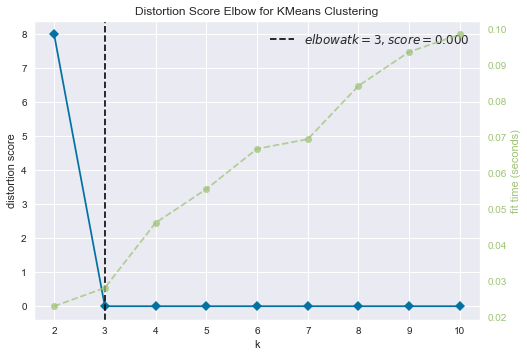

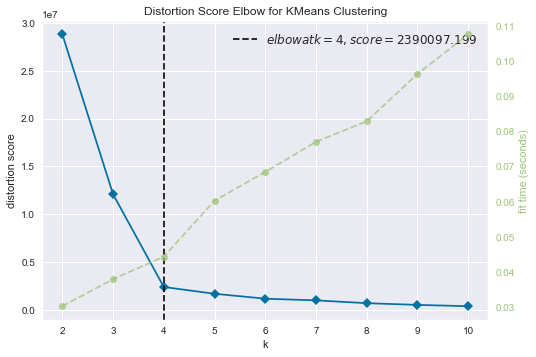

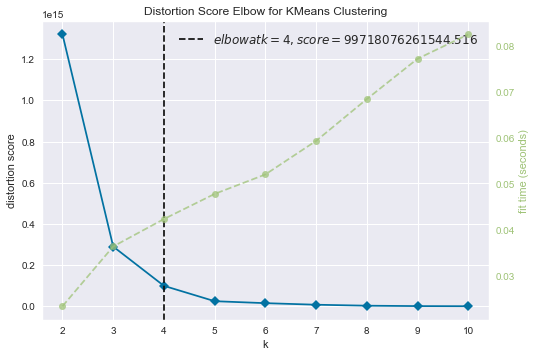

In [493]:
# Encode protocol names
pdata["Protocol"] = fam.encode_feature(pdata["Protocol"])

# Select infected host with most entries in dataset
infected_host = pdata.loc[pdata["SourceAddress"] == fam.select_infected_host(pdata)]

# Apply Elbow method to find optimal number of bins
for feature in ["Protocol","Duration","SourceBytes"]:
    fam.elbow(infected_host,feature)

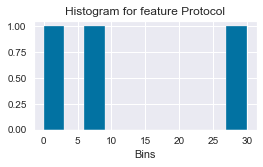

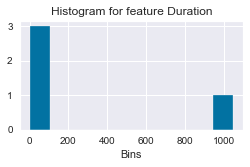

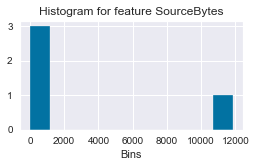

In [577]:
features = ["Protocol","Duration","SourceBytes"]
nbins = [3,4,4]

for feature, nbin in zip(features,nbins):
    X = np.array(infected_host[feature]).reshape(-1,1)
    enc = KBinsDiscretizer(n_bins=nbin, strategy="kmeans")
    X_binned = enc.fit_transform(X)
    binsedges = enc.bin_edges_[0]
    counts = pd.cut(np.array(infected_host[feature]), bins=binsedges).value_counts()

    fig, ax = plt.subplots(figsize=(4,2))
    plt.hist(counts)
    ax.set_xlabel("Bins")
    ax.set_title("Histogram for feature "+feature)
    plt.show()


